# Phase 4: Feature Engineering

**Goal**: Convert the cleaned AG News text into numeric feature matrices using TF-IDF vectorization (unigrams + bigrams), then export the fitted vectorizer and feature matrices for modeling.

**Inputs**
- `data/processed/clean_train.csv` — 120,000 rows
- `data/processed/clean_test.csv`  — 7,600 rows

**Outputs**
- `models/tfidf_vectorizer.joblib`
- `data/processed/X_train.npz`, `X_test.npz`
- `data/processed/y_train.npy`, `y_test.npy`

## 1. Imports & Setup

In [1]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import scipy.sparse as sp
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Make src/ importable — reload forces kernel to pick up the latest features.py
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import features as _features_mod
importlib.reload(_features_mod)
from features import FeatureEngineer

# Paths
PROCESSED_DIR = os.path.join('..', 'data', 'processed')
MODELS_DIR    = os.path.join('..', 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

CLASS_NAMES = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}

print('Setup complete.')

Setup complete.


## 2. Load Processed Data

In [2]:
train_df = pd.read_csv(os.path.join(PROCESSED_DIR, 'clean_train.csv'))
test_df  = pd.read_csv(os.path.join(PROCESSED_DIR, 'clean_test.csv'))

print(f'Train shape : {train_df.shape}')
print(f'Test  shape : {test_df.shape}')
train_df.head(3)

Train shape : (120000, 4)
Test  shape : (7600, 4)


,Class Index,Title,Description,Clean_Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",shortsellers wall street dwindlingband ultracy...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,private investment firm carlyle groupwhich rep...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,soaring crude price plus worriesabout economy ...


In [3]:
# Extract text and labels
X_train_text = train_df['Clean_Description'].fillna('').astype(str)
X_test_text  = test_df['Clean_Description'].fillna('').astype(str)

y_train = train_df['Class Index'].values
y_test  = test_df['Class Index'].values

print('Class distribution (train):')
print(pd.Series(y_train).map(CLASS_NAMES).value_counts())

Class distribution (train):
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


## 3. TF-IDF Vectorization

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| `ngram_range` | `(1, 2)` | Captures single words **and** two-word phrases |
| `max_features` | `50 000` | Caps vocabulary to control memory |
| `sublinear_tf` | `True` | Log-scales TF to dampen very frequent terms |
| `min_df` | `2` | Drops terms appearing in only one document |
| `strip_accents` | `unicode` | Normalises accented characters |

In [4]:
fe = FeatureEngineer(max_features=50_000)

print('Fitting TF-IDF on training set...')
X_train = fe.fit_transform(X_train_text)

print('Transforming test set...')
X_test = fe.transform(X_test_text)

print(f'\nX_train : {X_train.shape}  (sparsity: {1 - X_train.nnz / (X_train.shape[0]*X_train.shape[1]):.4%})')
print(f'X_test  : {X_test.shape}')

Fitting TF-IDF on training set...
Transforming test set...

X_train : (120000, 50000)  (sparsity: 99.9536%)
X_test  : (7600, 50000)


## 4. Vocabulary Inspection

In [5]:
vocab = fe.vectorizer.get_feature_names_out()
idf   = fe.vectorizer.idf_

print(f'Vocabulary size : {len(vocab):,}')

# Top 20 terms by highest IDF (most discriminative / rare)
top_idf_idx = np.argsort(idf)[::-1][:20]
print('\nTop 20 terms by IDF (most discriminative):')
for term, score in zip(vocab[top_idf_idx], idf[top_idf_idx]):
    print(f'  {term:<30} IDF={score:.4f}')

Vocabulary size : 50,000

Top 20 terms by IDF (most discriminative):
  trafficshield                  IDF=11.5966
  ltmeta                         IDF=11.5966
  gt ltmeta                      IDF=11.5966
  triano                         IDF=11.0858
  moreover                       IDF=11.0858
  font                           IDF=11.0858
  wrdb sr                        IDF=11.0858
  wrdb                           IDF=11.0858
  filemaker                      IDF=11.0858
  gigaset                        IDF=11.0858
  feedster                       IDF=11.0858
  shopping cart                  IDF=11.0858
  link popularity                IDF=10.9035
  walk water                     IDF=10.9035
  telemedia                      IDF=10.9035
  crpf                           IDF=10.9035
  cranberry                      IDF=10.9035
  cray                           IDF=10.9035
  crab                           IDF=10.9035
  acronym                        IDF=10.9035


In [6]:
# Split unigrams vs bigrams
unigrams = [t for t in vocab if ' ' not in t]
bigrams  = [t for t in vocab if ' ' in t]
print(f'Unigrams : {len(unigrams):,}')
print(f'Bigrams  : {len(bigrams):,}')

Unigrams : 17,758
Bigrams  : 32,242


## 5. Top TF-IDF Terms per Class

For each class, compute the **mean TF-IDF score** across all documents in that class, then display the top 15 terms.

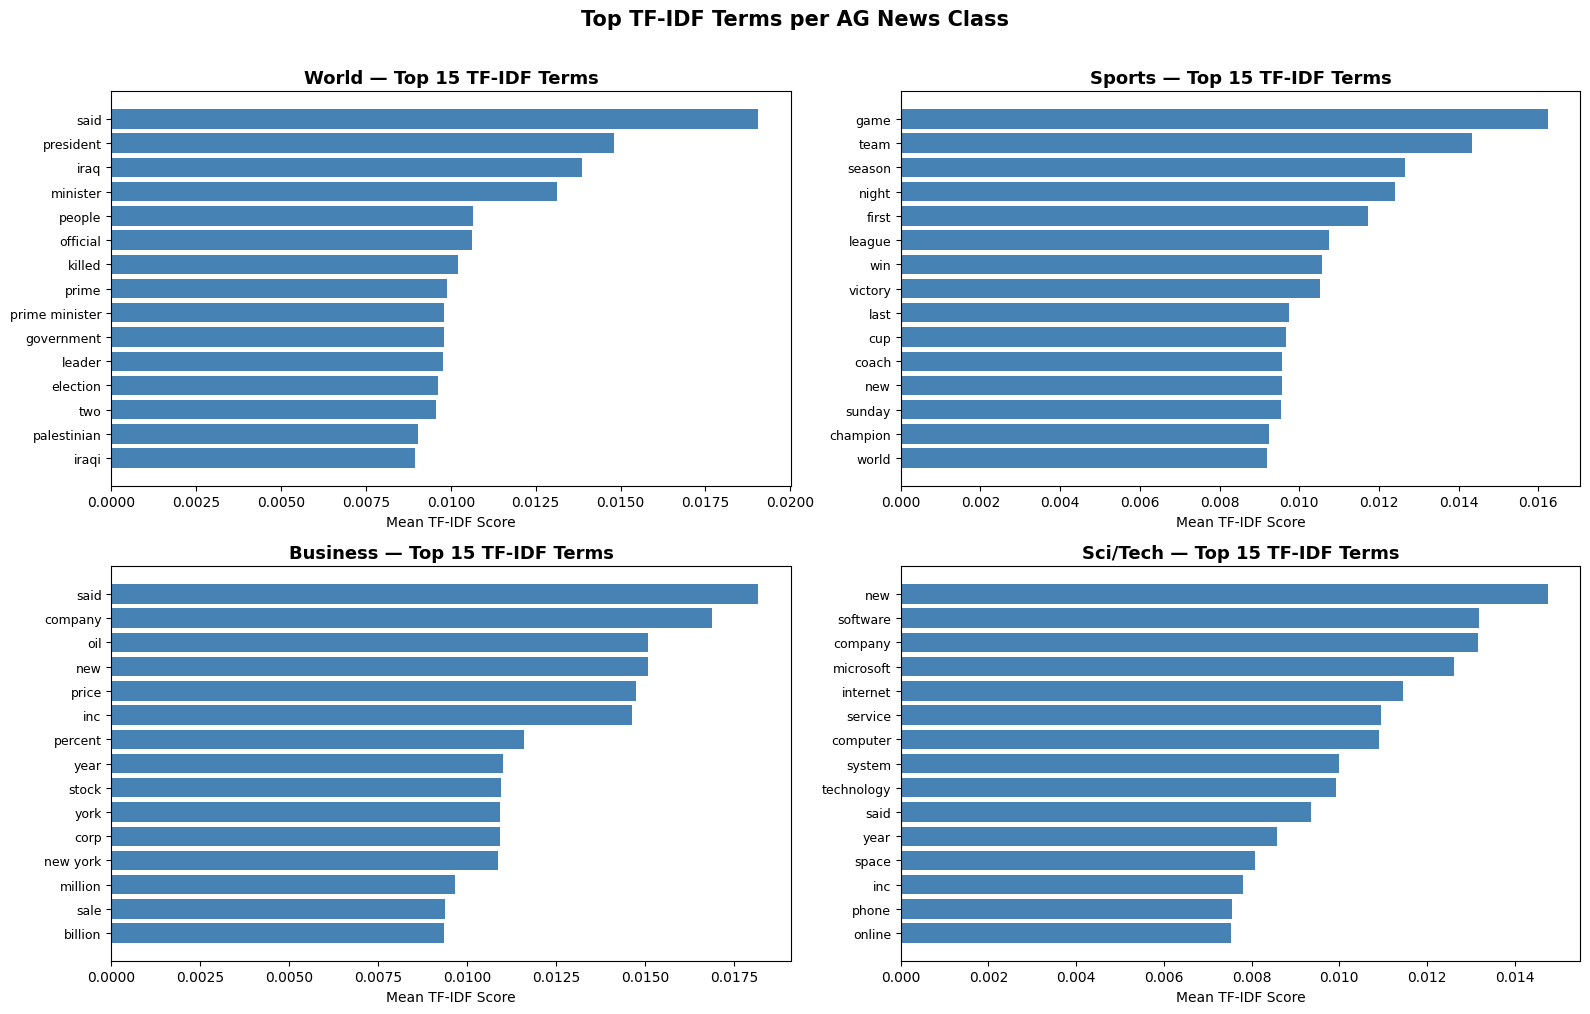

Plot saved to docs/phase4_top_terms.png


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, (class_idx, class_name) in zip(axes, CLASS_NAMES.items()):
    mask = (y_train == class_idx)
    mean_tfidf = np.asarray(X_train[mask].mean(axis=0)).flatten()
    top15_idx  = mean_tfidf.argsort()[::-1][:15]
    top15_terms = vocab[top15_idx]
    top15_scores = mean_tfidf[top15_idx]

    ax.barh(top15_terms[::-1], top15_scores[::-1], color='steelblue')
    ax.set_title(f'{class_name} — Top 15 TF-IDF Terms', fontsize=13, fontweight='bold')
    ax.set_xlabel('Mean TF-IDF Score')
    ax.tick_params(axis='y', labelsize=9)

plt.suptitle('Top TF-IDF Terms per AG News Class', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(os.path.join('..', 'docs', 'phase4_top_terms.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Plot saved to docs/phase4_top_terms.png')

## 6. Export Artifacts

In [8]:
# Save vectorizer
vectorizer_path = os.path.join(MODELS_DIR, 'tfidf_vectorizer.joblib')
fe.save(vectorizer_path)

# Save sparse feature matrices
sp.save_npz(os.path.join(PROCESSED_DIR, 'X_train.npz'), X_train)
sp.save_npz(os.path.join(PROCESSED_DIR, 'X_test.npz'),  X_test)
print('Sparse matrices saved.')

# Save labels
np.save(os.path.join(PROCESSED_DIR, 'y_train.npy'), y_train)
np.save(os.path.join(PROCESSED_DIR, 'y_test.npy'),  y_test)
print('Labels saved.')

print('\n--- Export Summary ---')
print(f'  Vectorizer : {vectorizer_path}')
print(f'  X_train    : {PROCESSED_DIR}/X_train.npz  {X_train.shape}')
print(f'  X_test     : {PROCESSED_DIR}/X_test.npz   {X_test.shape}')
print(f'  y_train    : {PROCESSED_DIR}/y_train.npy  {y_train.shape}')
print(f'  y_test     : {PROCESSED_DIR}/y_test.npy   {y_test.shape}')

Vectorizer saved → ..\models\tfidf_vectorizer.joblib
Sparse matrices saved.
Labels saved.

--- Export Summary ---
  Vectorizer : ..\models\tfidf_vectorizer.joblib
  X_train    : ..\data\processed/X_train.npz  (120000, 50000)
  X_test     : ..\data\processed/X_test.npz   (7600, 50000)
  y_train    : ..\data\processed/y_train.npy  (120000,)
  y_test     : ..\data\processed/y_test.npy   (7600,)


## 7. Quick Sanity Check

In [9]:
sample = 'stock market crash oil price surge economy'
vec    = fe.transform([sample])
scores = np.asarray(vec.todense()).flatten()
top5   = np.argsort(scores)[::-1][:5]

print(f'Sample text : "{sample}"')
print('Top 5 TF-IDF terms:')
for term, score in zip(vocab[top5], scores[top5]):
    print(f'  {term:<25} {score:.4f}')

Sample text : "stock market crash oil price surge economy"
Top 5 TF-IDF terms:
  surge                     0.4262
  stock market              0.4206
  crash                     0.4131
  economy                   0.3240
  oil price                 0.2953


---
**Phase 4 complete.** All artifacts exported. Proceed to Phase 5: Modeling.